In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [9]:
import copy

In [10]:
from functools import partial
from scipy import optimize

In [11]:
%matplotlib inline

In [12]:
from sklearn.model_selection._search import ParameterGrid

https://amypeniston.com/ditching-excel-for-python/

https://quantecon.org/python-lectures/ - tons of great example notebook. Done by top economists (Sargent). Mix of OO and non-OO just based on what makes the most sense. No need to be dogmatic.

Journal of Open Source Education - https://jose.theoj.org/

# Excel style "What if?" analysis with Python


## A little background and a question

Excel is widely used for building and using models of business problems to explore the impact of various model inputs on key outputs. Built in "what if?" tools such as Excel [Data Tables](https://support.microsoft.com/en-us/office/calculate-multiple-results-by-using-a-data-table-e95e2487-6ca6-4413-ad12-77542a5ea50b) and [Goal Seek](https://support.microsoft.com/en-us/office/use-goal-seek-to-find-the-result-you-want-by-adjusting-an-input-value-320cb99e-f4a4-417f-b1c3-4f369d6e66c7) are well known to power spreadsheet modelers. How might we do similar modeling and analysis using Python? 

While Python has been gaining momentum in the business analytics world, it is often used for data wrangling, analysis and visualization of tablular data using tools like pandas and matplotlib or Seaborn. I use Python all the time for such tasks. But, it got me to thinking. What about those things for which Excel is well suited such as building formula based models and doing sensitivity analysis on these models? What would those look like in Python?

For example, here's a high level screenshot of a model that I assign for homework in my [MIS 4460/5460 Business Analytics class]() (a spreadsheet based modeling class).
It's a really simple model in which we are selling a single product that we produce. There is a fixed cost to producing the product as well as a variable production cost per unit. We can sell the product for some price and we believe that demand for the product is related to the selling price through a power function. Let's assume for now that we have sufficient capacity to produce to demand and that all inputs are deterministic (we'll deal with simulating uncertainty later in this document).

TODO: Insert screenshot

The details aren't so important right now as is the overall structure of the model. There's a few key inputs and some pretty straightforward formulas for computing cost, revenue and profit. Notice the 1-way Data Table being used to explore how profit varies for different selling prices. There's a graph driven by the Data Table and some Text Boxes used for annotation and summeary interpretative comments. There's a button that launches Goal Seek to find the break even selling price and a 2-way Data Table to explore the joint effect of selling price and variable cost. Classic Excel modeling stuff. How might we go about building a similar model using Python?  

What if we wanted to push it a little further and model some of the key inputs with probability distributions to reflect our uncertainty about their values? In the Excel world, we might use add-ins such as @Risk which allow uncertain quantities to be directly modeled with probability distributions. For example, we might have a key input such as the exponent in the power function that relates selling price to demand that is highly uncertain. By modeling it with a probability distribution and then sampling from that distribution many times (essentially by recalcing the spreadsheet) we can generate a bunch of possible values for key outputs (e.g. profit) and use statistics to summarize these outputs using things like histograms and summary stats. Often this type of simulation model is referred to as a *Monte-Carlo* model to suggest repeated sampling from one or more probability distributions within an otherwise pretty static model. If you want to see such models in action, check out my [Simulation Modeling with Excel page](http://www.sba.oakland.edu/faculty/isken/courses/mis5460_w21/simulation.html) from my Business Analytics course. Again, how might we do this with Python?

In the remainder of this document, we'll explore these questions and along the way introduce some basic object-oriented (OO) programming concepts and other slightly more advanced Python techniques. This is aimed at those who might have a strong Excel based background but only a basic familiarity with Python programming. We are going to use a slightly different problem example than the one I've discussed above (we'll save that one for an "exercise for the motivated reader"). I've structured things as follows:

* The bookstore problem
    - Non-OO model for the bookstore problem
    - 1-, 2-, n-way Data Tables with the non-OO model
* Everything is an object in Python
* An OO model for the bookstore problem
    - 1-, 2-, n-way data tables with the OO model
* Goal Seek
    - a non-OO hornet's nest
    - the OO approach
* Monte-Carlo simulation
* Concluding thoughts


## Bookstore model

This example is based on one in the spreadsheet modeling textbook(s) I've used in my classes since 2001. I started out using Practical Management Science by Winston and Albright and switched to their Business Analytics: Data Analysis and Decision Making (Albright and Winston) around 2013ish. In both books, they introduce the "Walton Bookstore" problem in the chapter on Monte-Carlo simulation. Here's the basic problem (with a few modifications):

* we have to place an order for a perishable product (e.g. a calendar)
* there's a known unit cost for each one ordered
* we have a known selling price
* demand is uncertain but we can model it with some simple probability distribution
* for each unsold item, we can get a partial refund of our unit cost
* we need to select the order quantity for our one order for the year; orders can only be in multiples of 25


### Base model - non-OO approach
Starting simple, let's create some initialized variables for the base inputs.

In [13]:
demand_range = np.arange(50, 301, 5)
order_quantity_range = np.arange(50, 301, 25)

In [14]:
# Create data table (as a list of tuples)
data_table_1 = [(d, oq, bookstore_profit(unit_cost, selling_price, unit_refund, oq, d)) 
                 for d in demand_range for oq in order_quantity_range]

# Convert to dataframe
dtbl_1_df = pd.DataFrame(data_table_1, columns=['Demand', 'OrderQuantity', 'Profit'])
dtbl_1_df.head(25)

NameError: name 'bookstore_profit' is not defined

In [ ]:
class BookstoreModel():
    def __init__(self, unit_cost=0, selling_price=0, unit_refund=0, 
                 order_quantity=0, demand=0):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
        # Store initial inputs to use in reset method
        self._initial_inputs = vars(self)
        
    def update(self, param_dict):
        """
        Update parameter values
        """
        for key in param_dict:
            setattr(self, key, param_dict[key])
        
    def order_cost(self):
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        return np.maximum(0, self.order_quantity - self.demand)
    
    def profit(self):
        '''
        Compute profit in bookstore model
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
    
    def reset(self):
        """
        Reset model attributes to initial values. 
        """
        self.update(self._initial_inputs)
    
    def __str__(self):
        """
        Print dictionary of object attributes but don't include the _initial_inputs dict.
        """
        return str({key: val for (key, val) in vars(self).items() if key[0] != '_'})

In [ ]:
def data_table(model, scenario_inputs, outputs):
    # TODO: Validity checking of inputs and outputs
    
    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
            # Append the result dictionary to the results list
            results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

Okay, let's try it out. Also, since now the BookstoreModel class uses keyword arguments with defaults, I'm going to create a new model object in a slightly different way:
* create a new model object and just take the zero default values for the input attributes
* use the `update` method to set the input attributes via a dictionary

In [ ]:
# Create a dictionary of base input values

base_inputs = {'unit_cost': 7.5, 
               'selling_price': 10.0, 
               'unit_refund': 2.5, 
               'order_quantity': 200, 
               'demand': 193}

In [ ]:
# Create a new model with default input values (0's)
model_6 = BookstoreModel()
print(model_6)
model_6.profit()

In [ ]:
# Update model with base inputs
model_6.update(base_inputs)
print(model_6)

In [ ]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                   'order_quantity': np.arange(70, 321, 50)}

# Specify desired outputs (list)
outputs = ['profit', 'order_cost']

# Use data_table function
m6_dt1_df = data_table(model_6, dt_param_ranges, outputs)
m6_dt1_df

Let's plot the results using Seaborn.

In [ ]:
profit_dt_g = sns.FacetGrid(m6_dt1_df, col="order_quantity", sharey=True, col_wrap=3)
profit_dt_g = profit_dt_g.map(plt.plot, "demand", "profit")

#### Goal Seek

In addition to the type of sensitivity analysis enabled by the `data_table` function we created in the [first post in this series](), another typical Excel analytical task is to use Goal Seek to find, say, the break even level of demand. For example, let's find the break even demand for an order quantity of 250 and all other inputs at their base values.

At its core, Goal Seek is just a root finder. So, in the Python world, it feels like the optimization routines in SciPy might be useful. Let's start with the non-OO version of our Bookstore Model

Find break even demand for an order quantity of 250 and all other inputs at their base values.

Seems like using the `compute_profit` function is the way to go. Should be able to generalize to mulitple dimensions to create efficient frontier type outputs.

https://stackoverflow.com/questions/14261474/how-do-i-write-a-function-that-returns-another-function

https://docs.python.org/3/library/functools.html#partial-objects

https://stackoverflow.com/questions/37052253/choose-which-variable-to-solve-for-python-root-finding-using-fsolve

Actually, as you'll see below, this is quite a hornet's nest of meta-programming caused by the need to partially freeze the function for use with scipy.optimize but in which we don't know in advance which parameter will be the free one.

Perhaps this would be easier with the OO version. That turned out to be pretty easy to use for data tables. ... Well, not seeing obvious way to do this with OO especially since the function I want to goal seek calls other methods within the model class. Thinking I need to not use scipy.optimize and just write it myself.

https://github.com/patrickwalls/mathematical-python/ - has nice implementation of various root finding methods

In [ ]:
def bisection(f,a,b,N):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    if f(a)*f(b) >= 0:
        print("Bisection method fails.")
        return None
    a_n = a
    b_n = b
    for n in range(1,N+1):
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
    return (a_n + b_n)/2

In [ ]:
def goal_seek(model, obj_fn, target, by_changing, a, b, N=100):
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # The following bisection search is a direct adaptation of
    # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
    # The changes include needing to use an object method instead of a global function
    # and the inclusion of a non-zero target value.
    
    setattr(model_clone, by_changing, a)
    f_a_0 = getattr(model_clone, obj_fn)()
    setattr(model_clone, by_changing, b)
    f_b_0 = getattr(model_clone, obj_fn)()
    
    if (f_a_0 - target) * (f_b_0 - target) >= 0:
        print("Bisection method fails.")
        return None
    
    a_n = a
    b_n = b
    for n in range(1, N+1):
        m_n = (a_n + b_n)/2
        
        setattr(model_clone, by_changing, m_n)
        f_m_n = getattr(model_clone, obj_fn)()
        
        setattr(model_clone, by_changing, a_n)
        f_a_n = getattr(model_clone, obj_fn)()
        
        setattr(model_clone, by_changing, b_n)
        f_b_n = getattr(model_clone, obj_fn)()

        if (f_a_n - target) * (f_m_n - target) < 0:
            a_n = a_n
            b_n = m_n
        elif (f_b_n - target) * (f_m_n - target) < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == target:
            print("Found exact solution.")
            return (m_n, n)
        else:
            print("Bisection method fails.")
            return None
    
    return ((a_n + b_n)/2, n)

In [ ]:
print(model1)

In [ ]:
model1.profit()

In [ ]:
goal_seek(model1, 'profit', 0.0, 'demand', 100, 500, N=100)

In [ ]:
goal_seek(model1, 'profit', 0.0, 'selling_price', 1.0, 25.0, N=100)

## Attempt at non-OO version of Goal Seek

This got nasty but led down all kinds of interesting side paths having to do with partial function freezing, lambda functions, currying, function signatures and more.

In [ ]:
# Set all of our base input values
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

demand = 193

order_quantity = 250

Back in the first post in this series, we then created a function that took all of our base inputs as input arguments and returned a value for profit.

In [55]:
def bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):
    '''
    Compute profit in bookstore model
    '''
    order_cost = unit_cost * order_quantity
    sales_revenue = np.minimum(order_quantity, demand) * selling_price
    refund_revenue = np.maximum(0, order_quantity - demand)
    profit = sales_revenue + refund_revenue - order_cost
    return profit

Let's try it out.

In [ ]:
bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand)

### A bit about root finding using a simpler example

Now let's try to find the break even value for demand; i.e. the level of demand that leads to a profit of 0. As mentioned above, this is a root finding problem - finding where the profit function crosses the x-axis. The SciPy package has various root finding and optimization functions. The main page is:

https://docs.scipy.org/doc/scipy/reference/optimize.html

Reading that page, we eventually get down to the root finding section and find the main function, [root_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar). Before trying to use this this function for our bookstore model, let's consider a simpler example. In fact, let's consider a simple one variable function.

In [24]:
def simple_function(x):
    '''x^2 - 3x - 5'''
    return x ** 2 - 3 * x - 5

In [25]:
simple_function(2)

-7

In [26]:
simple_function(10)

65

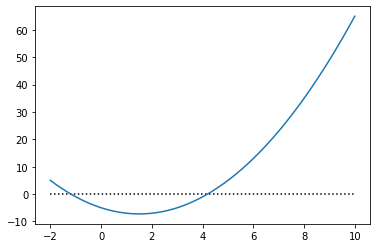

In [28]:
left_bracket = -2
right_bracket = 10
x = np.linspace(left_bracket, right_bracket)
y = simple_function(x)
plt.plot(x, y)
plt.hlines(0, left_bracket, right_bracket, linestyles='dotted')
plt.show()

To use `scipy.optimize.root_scalar` to find the value of `x` where `simple_function(x)` is equal to zero, we call the `root_scalar` and pass in the following input arguments:

* the function - in our case, this is `simple_function`
* the root finding method - we'll use `bisect` as it's simple, converges, and doesn't require any derivative information. See https://www.youtube.com/watch?v=BuwjGi8J5iA for an explanation of how bisection search works and how it can be eaily implemented in Python.
* a bracket (required for some methods) - if we can define a range `[a, b]` within which we know the root occurs such that $f(a)$ and $f(b)$ have different signs, we can supply it. For example, in our `simple_function` example, we know it must cross zero somewhere between [-2, 0] and then again betwen [0, 10]. Yes, it might cross zero more than once - see plot. As you can imagine such a bracket will help immensely when there are multiple roots and lessen the effect of the initial guess.
* an initial guess (optional) - many root finding algorithms will perform better if we are able to give a reasonable guess as to where the root might be.

If you've ever used Excel's Goal Seek tool, you may have stumbled on behaviors that are related to the list and plot above.

* Goal Seek doesn't allow you to tell it a whole lot in terms of how it attempts to find roots. We don't get to specify the method and we don't get to bracket the root. But, ...
* Goal Seek does use the current cell value of the *Changing Cell* as an initial guess
* If our spreadsheet model does have multiple roots, the root returned by Goal Seek will depend on our initial guess.

For example, here are the results of using Goal Seek to drive `simple_function(x)` to 0 with different initial guesses. Note that the function is minimized at $x=1.5$.

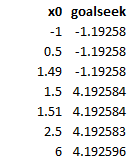

Let's try a few different root finding functions available in SciPy.

* `fsolve` - this appears to be a legacy function but doesn't require us to bracket the root such that $f(a)$ and $f(b)$ have different signs. Of course, the root it returns will likely be impacted by the initial guess (just as Goal Seek is).  
* `root_scalar` - this is a newer, more general, function for which we can specify specifics such as the root finding algorithm. Most of the methods require a root bracket.

In [36]:
from scipy.optimize import root_scalar
from scipy.optimize import fsolve

In [38]:
# fsolve - very similar to Goal Seek
init_values = [-1, 0.5, 1.49, 1.5, 1.51, 2.5, 6]

[(x, fsolve(simple_function, x)) for x in init_values]
    

[(-1, array([-1.1925824])),
 (0.5, array([-1.1925824])),
 (1.49, array([-1.1925824])),
 (1.5, array([4.1925824])),
 (1.51, array([4.1925824])),
 (2.5, array([4.1925824])),
 (6, array([4.1925824]))]

In [45]:
# Left root
init_values_1 = [-1, -0.5, 0.0]
[(x, root_scalar(simple_function, method='bisect', bracket=[-2, 0], x1=x).root) for x in init_values_1]

[(-1, -1.1925824035661208),
 (-0.5, -1.1925824035661208),
 (0.0, -1.1925824035661208)]

In [46]:
# Right root
init_values_2 = [0.0, 0.5, 1, 4, 10]
[(x, root_scalar(simple_function, method='bisect', bracket=[0, 10], x1=x).root) for x in init_values_2]
    

[(0.0, 4.192582403567258),
 (0.5, 4.192582403567258),
 (1, 4.192582403567258),
 (4, 4.192582403567258),
 (10, 4.192582403567258)]

Great. In this contrived case in which we can easily write a function to compute the derivative of `simple_function`, we could use Newton's method instead of bisection search (or others) that require bracketing. Sometimes, just bracketing the root might be really hard. Of course, then the initial guess will matter a lot and we should be able to duplicate Goal Seek's behavior. In real spreadsheet life, we probably don't have a closed form solution for the derivative, though we could likely approximate it pretty well as long as it wasn't super jumpy. 

Check out http://www.math.pitt.edu/~troy/math2070/lab_04.html if you want to play around in Python with different root finding algorithms.

Anyway, let's do it.

In [47]:
def simple_function_prime(x):
    '''Derivative of x^2 - 3x - 5'''
    return 2 * x - 3

In [49]:
init_values = [-1, 0.5, 1.49, 1.5, 1.51, 2.5, 6]

[(x, root_scalar(simple_function, method='newton', fprime=simple_function_prime, x0=x).root) for x in init_values]

C:\Users\isken\AppData\Local\Continuum\anaconda3\envs\datasci\lib\site-packages\scipy\optimize\zeros.py:295: RuntimeWarning: Derivative was zero.
  warnings.warn(msg, RuntimeWarning)


[(-1, -1.192582403567252),
 (0.5, -1.1925824035672519),
 (1.49, -1.192582403567252),
 (1.5, 1.5),
 (1.51, 4.192582403567251),
 (2.5, 4.192582403567252),
 (6, 4.192582403567252)]

Notice that with Newton's Method, we got the same behavior as Goal Seek, except for when we used an initial guess of 1.5. Of course, this is the point at which `simple_function` is minimized and the derivative is 0. We get a warning about that and instead of arbitrarily going in one direction or the other, `root_scalar` just bailed and gave us back our original guess. These root finding functions actually [return much more info than just the root](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.RootResults.html#scipy.optimize.RootResults).

In [50]:
print(root_scalar(simple_function, method='newton', fprime=simple_function_prime, x0=1))

      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 7
           root: -1.192582403567252


In [51]:
print(root_scalar(simple_function, method='newton', fprime=simple_function_prime, x0=1.5))

      converged: False
           flag: 'convergence error'
 function_calls: 2
     iterations: 1
           root: 1.5


Try out different methods and you'll see that some take longer than others to converge. Bisection search is [known to be slow but safe](https://www.youtube.com/watch?v=MlP_W-obuNg&t=138s).

In [52]:
print(root_scalar(simple_function, method='bisect', bracket=[0, 10], x1=1))

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 43
           root: 4.192582403567258


### Back to the Bookstore Model 
You may have already been wondering how exactly we might use SciPy's root finding functions with our `bookstore_profit` function since it doesn't just have one input argument, it's got five. How do we tell `root_scalar` which one of the inputs (e.g. demand) is the one we want to search over and that we want all the other arguments to remain fixed at specific values? This is a job for something known as a [partial function](https://www.learnpython.org/en/Partial_functions). The idea is to create a new function object that is based on an existing function, but with some of the function's inputs set to fixed values. To create partial functions, we need to use the `partial` function from the `functools` library. Unfortunately, while this initially seemed easy, we quickly ran into problems. Before describing those, let's cheat and consider an easier case. Instead of `demand` being the input we want to vary (i.e. do the Goal Seek on), let's use `unit_cost`. You'll notice that `unit_cost` is the first input argument to `bookstore_profit` and this might give you an idea of why things get difficult when we want to do this for `demand`.

In [ ]:
from functools import partial

In [76]:
selling_price = 10.00
unit_refund = 2.50
order_quantity = 200
demand = 193

profit_unit_cost = partial(bookstore_profit, selling_price=selling_price,
                   unit_refund=unit_refund, demand=demand, order_quantity=order_quantity)

In [77]:
type(profit_unit_cost)

functools.partial

Let's just make sure it works and then we'll try some goal seeking. We know that for the inputs above and a unit cost of $7.50, we should get a profit of 437.

In [78]:
profit_unit_cost(7.50)

437.0

Let's try to find a positive root. First let's bracket it. If we have really low unit cost, we should have have a big positive profit. If we have a high unit cost, we should lose money.

In [63]:
profit_unit_cost(1)

1737.0

In [64]:
profit_unit_cost(10)

-63.0

In [65]:
root_scalar(profit_unit_cost, method='bisect', bracket=[1, 10], x1=1)

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 43
           root: 9.685000000000286

Terrific. But what happens if we try to do this to find the break even demand level?

In [79]:
# Set all of our base input values
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
order_quantity = 200

Create a new partial function. Watch what happens when we try to use it.

In [69]:
profit_demand = partial(bookstore_profit, unit_cost=unit_cost, selling_price=selling_price,
                   unit_refund=unit_refund, order_quantity=order_quantity)

In [71]:
# print(profit_demand(193))
'''
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-70-babba58828f2> in <module>
----> 1 print(profit_demand(193))

TypeError: bookstore_profit() got multiple values for argument 'unit_cost'
'''

"\n---------------------------------------------------------------------------\nTypeError                                 Traceback (most recent call last)\n<ipython-input-70-babba58828f2> in <module>\n----> 1 print(profit_demand(193))\n\nTypeError: bookstore_profit() got multiple values for argument 'unit_cost'\n"

What happened? Well our new partial function is taking a single positional argument. Since `unit_cost` is the first argument in our original function definition, it wants to assign the 193 to `unit_cost`. Then, when also supply the `unit_cost=unit_cost` named argument, Python complains because `unit_cost` already has a value. We didn't get the error when we goal seeked for `unit_cost` because it's the first argument in the original function. The bigger issue is that we don't know which of our five input arguments the user might want to use for goal seeking. In essence, we need to wrap our original function in another function that does nothing but move the goal seek variable into the first position of the function's argument list. Feels like a job for a lambda function. See https://stackoverflow.com/questions/51583924/python-typeerror-multiple-arguments-with-functools-partial for a good discussion of this issue and a lambda function based solution.

In [80]:
profit_demand_2 = partial(lambda d, uc, sp, uf, oq: bookstore_profit(uc, sp, uf, oq, d),
                          uc=unit_cost, sp=selling_price, 
                          uf=unit_refund,
                          oq=order_quantity)

In [86]:
print(profit_demand_2(0))

-1300.0


In [87]:
print(profit_demand_2(193))

437.0


In [88]:
root_scalar(profit_demand_2, method='bisect', bracket=[0, 193], x1=1)

      converged: True
           flag: 'converged'
 function_calls: 49
     iterations: 47
           root: 144.4444444444448

Yep, this matches what I found with Excel's Goal Seek tool. Unfortunately, this is not a very satisfying solution since we custom crafted a lambda function to alter the *function signature* of `bookstore_profit` specifically to work for the `demand` input. But, what if we want a different input variable to be the subject of our goal seek (the "changing cell" in Excel terminology). For example, we might want to find the break even selling price. 

## And down the rabbit hole, we go
By the way, you can see any function's signature with the help system.

In [90]:
bookstore_profit?

Signature:
bookstore_profit(
    unit_cost,
    selling_price,
    unit_refund,
    order_quantity,
    demand,
)
Docstring: Compute profit in bookstore model
File:      c:\users\isken\documents\teaching\aap\basic_modeling_oo\<ipython-input-55-bba48c252a04>
Type:      function


In [89]:
profit_demand_2?

Signature:      profit_demand_2(d, *, uc=7.5, sp=10.0, uf=2.5, oq=200)
Call signature: profit_demand_2(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function <lambda> at 0x00000186949C3EE8>, uc=7.5, sp=10.0, uf=2.5, oq=200)
File:           c:\users\isken\appdata\local\continuum\anaconda3\envs\datasci\lib\functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.


In [107]:
profit_demand.keywords

{'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200}

In [108]:
profit_demand.func

<function __main__.compute_profit(unit_cost, selling_price, unit_refund, order_quantity, demand)>

In [109]:
profit_demand(demand=demand)

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

In [110]:
demand

array([ 70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320])

In [111]:
profit_demand_2(demand)

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

In [112]:
optimize.root_scalar(profit_demand_2, bracket=[0, 500])

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 144.44444444444443

In [113]:
profit_demand_2?

Signature:      profit_demand_2(d, *, uc=7.5, sp=10.0, uf=2.5, oq=200)
Call signature: profit_demand_2(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function <lambda> at 0x7f7488f83ee0>, uc=7.5, sp=10.0, uf=2.5, oq=200)
File:           ~/anaconda3/envs/mginf/lib/python3.8/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.


Ok, so for a given variable for which to goal seek, we can write a partial lambda function to do the goal seek. Now, how can we create a function that creates the partial lambda function and that takes as input the base `compute_profit` function and the name of the keyword arg representing the decision variable?

https://stackoverflow.com/questions/14261474/how-do-i-write-a-function-that-returns-another-function

https://en.wikipedia.org/wiki/Currying

In [114]:
compute_profit?

Signature:
compute_profit(
    unit_cost,
    selling_price,
    unit_refund,
    order_quantity,
    demand,
)
Docstring: Compute profit in bookstore model
File:      ~/Documents/teaching/adv_analytics/abm/notebooks/<ipython-input-78-30ab07516e02>
Type:      function


In [116]:
compute_profit.__doc__

'\n    Compute profit in bookstore model\n    '

In [117]:
compute_profit.__dict__

{}

https://docs.python.org/3/library/inspect.html

https://treyhunner.com/2018/04/keyword-arguments-in-python/

In [118]:

import inspect

In [119]:
inspect.getdoc(compute_profit)

'Compute profit in bookstore model'

Signature objects are important and powerful for function programming.

https://www.python.org/dev/peps/pep-0362/

In [120]:
inspect.signature(compute_profit)

<Signature (unit_cost, selling_price, unit_refund, order_quantity, demand)>

In [121]:
dir(inspect.signature(compute_profit))

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_bind',
 '_bound_arguments_cls',
 '_hash_basis',
 '_parameter_cls',
 '_parameters',
 '_return_annotation',
 'bind',
 'bind_partial',
 'empty',
 'from_builtin',
 'from_callable',
 'from_function',
 'parameters',
 'replace',
 'return_annotation']

In [122]:
sig = inspect.signature(compute_profit)
sig.parameters

mappingproxy({'unit_cost': <Parameter "unit_cost">,
              'selling_price': <Parameter "selling_price">,
              'unit_refund': <Parameter "unit_refund">,
              'order_quantity': <Parameter "order_quantity">,
              'demand': <Parameter "demand">})

In [123]:
sig.parameters['unit_cost']

<Parameter "unit_cost">

In [124]:
sig.parameters['unit_cost'].replace(default=100)

<Parameter "unit_cost=100">

In [134]:
#dir(sig.parameters)

In [126]:
for item in sig.parameters.items():
    print(item)
    print(item[1].name)
    print(item[1].default)

('unit_cost', <Parameter "unit_cost">)
unit_cost
<class 'inspect._empty'>
('selling_price', <Parameter "selling_price">)
selling_price
<class 'inspect._empty'>
('unit_refund', <Parameter "unit_refund">)
unit_refund
<class 'inspect._empty'>
('order_quantity', <Parameter "order_quantity">)
order_quantity
<class 'inspect._empty'>
('demand', <Parameter "demand">)
demand
<class 'inspect._empty'>


In [127]:
inspect.getsource(compute_profit)

"def compute_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):\n    '''\n    Compute profit in bookstore model\n    '''\n    order_cost = unit_cost * order_quantity\n    sales_revenue = np.minimum(order_quantity, demand) * selling_price\n    refund_revenue = np.maximum(0, order_quantity - demand)\n    profit = sales_revenue + refund_revenue - order_cost\n    return profit\n"

In [128]:
inspect.getsourcelines(compute_profit)[0]

['def compute_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):\n',
 "    '''\n",
 '    Compute profit in bookstore model\n',
 "    '''\n",
 '    order_cost = unit_cost * order_quantity\n',
 '    sales_revenue = np.minimum(order_quantity, demand) * selling_price\n',
 '    refund_revenue = np.maximum(0, order_quantity - demand)\n',
 '    profit = sales_revenue + refund_revenue - order_cost\n',
 '    return profit\n']

In [135]:
#inspect.getmembers(compute_profit)

In [130]:
var = "demand"
# Create dictionary of key word args for all but var 
# The parameters attribute is an OrderedDict (see PEP 362)
fixed_inputs = {key:value for (key, value) in sig.parameters.items() if
                   key != var}
var_input = {key:value for (key, value) in sig.parameters.items() if
                   key == var}

In [131]:
print(fixed_inputs)
print(var_input)

{'unit_cost': <Parameter "unit_cost">, 'selling_price': <Parameter "selling_price">, 'unit_refund': <Parameter "unit_refund">, 'order_quantity': <Parameter "order_quantity">}
{'demand': <Parameter "demand">}


https://stackoverflow.com/questions/938429/scope-of-lambda-functions-and-their-parameters

In [132]:
fixed_inputs = {'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200}

def make_partial_profit(fn, fixed_inputs, var_input):
     
    partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          **fixed_inputs)

In [133]:
profit_demand_2 = partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          uc=unit_cost, sp=selling_price, 
                          uf=unit_refund,
                          oq=order_quantity)

#### Monte-carlo sim

We can do MC sim using both OO and non-OO versions of our model using the same ideas as we did for creating data tables. For the non-OO we can generate a vector of random demand realizations and then feed that vector to our `compute_profit` function. We'll end up with a vector of profits with the same number of elements as in our demand vector. Then we can analyze the results with statistics and histograms, for example.

Recently, numpy has updated their random variable generation routines. The details are at:

https://numpy.org/doc/stable/reference/random/index.html




The `scipy.stats` module contains a large number of probability distributions. Each has numerous functions for calculating things such as pdf or CDF values, quantiles, and various moments. There are also functions for generating random variates from these distributions. You can see the details at https://docs.scipy.org/doc/scipy/reference/stats.html.

Let's assume we want to model demand with a normal distribution. If you recall, we already initialized variables `demand_mean` and `demand_sd` with the mean and standard deviation of demand. We'll use these.

First we import the necessary function from `scipy.stats` and then we can generate the normally distributed random variates. I'm going to generate 1000 variates. To make sure this worked, we can create a histogram of the random variates and we expect it to be pretty bell-shaped. We can also overlay the normal density function for a normal distribution with the specified mean and standard deviation. 

In [136]:
print(f"Demand mean = {demand_mean}")
print(f"Demand sd = {demand_sd}")

Demand mean = 193
Demand sd = 40


In [137]:
from scipy.stats import norm

First we need to import the default random number generator and create a random generator variable. I'll use 4470 as the seed. This generator generates numbers uniformly between 0 and 1. Then we use it to generate random variates from whatever distribution we choose.

In [138]:
from numpy.random import default_rng
rg = default_rng(4470)
rg.random()

0.45855804438027437

In [139]:
demand_sim = rg.normal(demand_mean, demand_sd, 1000)

Obviously we are generating variates from a continuous distribution.

In [140]:
demand_sim[:10]

array([217.03616307, 133.37168121, 231.54405167, 215.05711803,
       183.66669223, 268.28497816, 255.99191635, 188.58125604,
       164.62174798, 170.1384389 ])

If we want integer valued demands, we can simply round the values.

In [141]:
demand_sim = np.around(rg.normal(demand_mean, demand_sd, 1000))
demand_sim[:10]

array([218., 203., 186., 203., 215., 151., 255., 176., 223., 252.])

Before plotting the histogram, let's compute basic summary stats for our vector of random demands.

In [142]:
print(f"Mean demand = {demand_sim.mean():.3f}, Std dev demand = {demand_sim.std():.3f}")

Mean demand = 192.056, Std dev demand = 40.170


Now let's use scipy to create a normal random variable instance with the mean and standard deviation based on `demand_mean` and `demand_sd`. Note the data type. Then we'll be able to use its built in `pdf` method to plot its density and its `ppf` method to get percentiles to use for our x-axis limits.

In [143]:
rv_normal = norm(loc=demand_mean, scale=demand_sd)
print(type(rv_normal))

<class 'scipy.stats._distn_infrastructure.rv_frozen'>


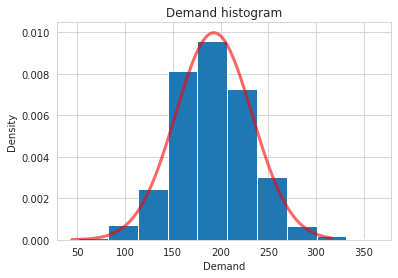

In [144]:
plt.title("Demand histogram")
plt.xlabel("Demand")
plt.ylabel("Density")
plt.hist(demand_sim, density=True);

x_normal = np.linspace(rv_normal.ppf(0.0001),
                rv_normal.ppf(0.999), 500)

plt.plot(x_normal, rv_normal.pdf(x_normal),
       'r-', lw=3, alpha=0.6, label='Normal pdf');

Now that we can generate random demands, we can "simulate" by simply passing in the vector of random demands to the `compute_profit` function (all the other model inputs are held fixed at their current values. Let's remind ourselves of these values.

In [145]:
message = f"unit_cost: {unit_cost} \n" \
          f"selling_price: {selling_price} \n" \
          f"unit_refund: {unit_refund} \n" \
          f"order_quantity: {order_quantity}"

print(message)

unit_cost: 7.5 
selling_price: 10.0 
unit_refund: 2.5 
order_quantity: 200


Again, note how we use a list comprehension to evaluate profit for each demand realization. This is exactly the same way we did the non-OO 1-way data table above. If we have multiple random inputs we cannot use multiple for statements as we don't want the cross product of the random number vectors. Instead we'd need to zip them up into tuples.

In [57]:
alpha = [1, 2, 3]
beta = [10, 20, 30]

for t in zip(alpha, beta):
    print(t)

(1, 10)
(2, 20)
(3, 30)


Let's wrap the resulting list with the pandas `Series` constructor so that we can use some of pandas built in analysis tools such as the `describe` method.

In [146]:
profit_sim = pd.Series([(compute_profit(unit_cost, selling_price, 
                              unit_refund, order_quantity, d)) 
               for d in demand_sim])



In [147]:
profit_sim.describe()

count    1000.000000
mean      317.399000
std       228.756476
min      -841.000000
25%       191.750000
50%       419.000000
75%       500.000000
max       500.000000
dtype: float64

The *Flaw of Averages* shows up here (compare mean of sim output to the profit we got by replacing demand with mean demand).

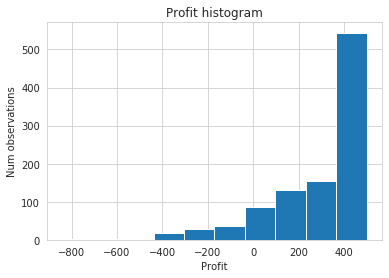

In [148]:
plt.title("Profit histogram")
plt.xlabel("Profit")
plt.ylabel("Num observations")
plt.hist(profit_sim, density=False);


In [149]:
from scipy import stats

In [150]:
# Probability between -200, 200
print(stats.percentileofscore(profit_sim, 200))
print(stats.percentileofscore(profit_sim, -200))
print(stats.percentileofscore(profit_sim, 200) - stats.percentileofscore(profit_sim, -200))

26.2
4.0
22.2


In [151]:
cdf = stats.cumfreq(profit_sim)

In [152]:
x = cdf.lowerlimit + np.linspace(0, cdf.binsize*cdf.cumcount.size,
                                 cdf.cumcount.size)

(-915.5, 574.5)

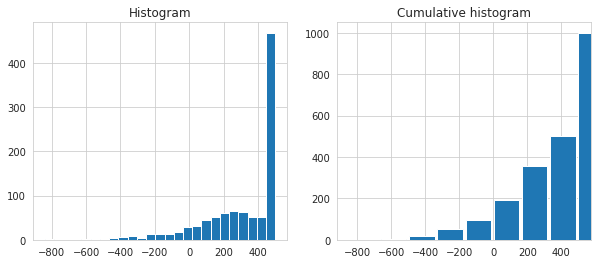

In [153]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(profit_sim, bins=25)
ax1.set_title('Histogram')
ax2.bar(x, cdf.cumcount, width=cdf.binsize)
ax2.set_title('Cumulative histogram')
ax2.set_xlim([x.min(), x.max()])

## Repeat simulation using OO approach
Just as we leveraged our non-OO data table approach for simulation, let's do the same for the OO version. We should be able to leverage scikit-learn's `ParameterGrid` function for optional scenario generation (think RiskSimTable). We don't want to use `ParameterGrid` for the random inputs as we don't want all combinations of them - we just want to evaluate one replication per row.

In [154]:
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

order_quantity = 200

demand_mean = 193
demand_sd = 40

demand = demand_mean

In [155]:
model2 = BookstoreModel(unit_cost=unit_cost, 
                        selling_price=selling_price,
                        unit_refund=unit_refund,
                        order_quantity=order_quantity,
                        demand=demand)

In [156]:
random_inputs = {'demand': np.around(rg.normal(demand_mean, demand_sd, 100))}
scenario_inputs = {'order_quantity': np.arange(70, 321, 50)}
sim_outputs = ['profit']

In [157]:
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [158]:
# Yes, this works. Now let's see if it makes sense to do the simulation this way. Looping over scenario inputs 
# but using vector assignment for the random inputs.
# model2.update(random_inputs)

In [159]:
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [160]:
list(ParameterGrid(scenario_inputs))

[{'order_quantity': 70},
 {'order_quantity': 120},
 {'order_quantity': 170},
 {'order_quantity': 220},
 {'order_quantity': 270},
 {'order_quantity': 320}]

In [161]:
def simulate(model, random_inputs, outputs, scenario_inputs=None, keep_random_inputs=False):
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # Update clone with random_inputs
    #for rnd_inp in random_inputs:
    model_clone.update(random_inputs)
    
    if keep_random_inputs:
        scenario_base_vals = vars(model_clone)
    else:
        scenario_base_vals = vars(model)
    
    
    scenario_num = 1
    scenario_results = []
    
    # Create parameter grid
    if scenario_inputs is not None:
        sim_param_grid = list(ParameterGrid(scenario_inputs))
        
        for params in sim_param_grid:
            model_clone.update(params)
            result = {}
            scenario_vals = copy.copy(params)
            result['scenario_base_vals'] = scenario_base_vals
            result['scenario_num'] = scenario_num
            result['scenario_vals'] = scenario_vals
            raw_output = {}
            for output_name in outputs:
                output_array = getattr(model_clone, output_name)()
                raw_output[output_name] = output_array
                
            result['output'] = raw_output
            scenario_results.append(result)
            scenario_num += 1
                
        return scenario_results

    else:
        results = []
        result = {}

        result['scenario_base_vals'] = scenario_base_vals
        result['scenario_num'] = scenario_num
        result['scenario_vals'] = {}
        
        raw_output = {}
        for output_name in outputs:
            output_array = getattr(model_clone, output_name)()
            raw_output[output_name] = output_array
            
        result['output'] = raw_output  
        results.append(result)

        return results

In [162]:
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [163]:
model2_results = simulate(model2, random_inputs, sim_outputs, scenario_inputs)

In [164]:
model2_results[0].keys()

dict_keys(['scenario_base_vals', 'scenario_num', 'scenario_vals', 'output'])

In [170]:
for scenario in model2_results:
    print(scenario['scenario_num'])

1
2
3
4
5
6


In [166]:
model2_results[0]['scenario_vals']

{'order_quantity': 70}

In [167]:
print(type(model2_results[0]['output']))
model2_results[0]['output']

<class 'dict'>


{'profit': array([175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175.])}

In [168]:
for scenario in model2_results:
    print(scenario['scenario_num'], scenario['scenario_vals'], type(scenario['output']), scenario['output']['profit'].mean())

1 {'order_quantity': 70} <class 'dict'> 175.0
2 {'order_quantity': 120} <class 'dict'> 298.74
3 {'order_quantity': 170} <class 'dict'> 356.15
4 {'order_quantity': 220} <class 'dict'> 252.91
5 {'order_quantity': 270} <class 'dict'> -11.88
6 {'order_quantity': 320} <class 'dict'> -329.5


In [169]:
model2_results[0]

{'scenario_base_vals': {'unit_cost': 7.5,
  'selling_price': 10.0,
  'unit_refund': 2.5,
  'order_quantity': 200,
  'demand': 193},
 'scenario_num': 1,
 'scenario_vals': {'order_quantity': 70},
 'output': {'profit': array([175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175.])}}

In [193]:
for scenario in model2_results:
    for key in scenario['output'].keys():
        print (key)
    

profit
profit
profit
profit
profit
profit


Let's write a gather results function to turn results object into analysis ready DataFrame.

In [ ]:
def gather_sim_results(results):
    

Hmmm, so we have a result object but need to get them into a nicely structured DataFrame to make stats and plotting easy. Perhaps we can go back to the ParameterGrid / DataTable approach if we zip the random vectors into tuples and then create the grid. Then we get data table output for free.

https://realpython.com/python-zip-function/

In [67]:
demand_sim = np.around(rg.normal(demand_mean, demand_sd, 100))
unit_cost_sim = np.around(rg.normal(unit_cost, 1.0, 100))

In [71]:
random_input_tuples = list(zip(demand_sim, unit_cost_sim))

print(random_input_tuples[:10])

[(207.0, 8.0), (225.0, 7.0), (113.0, 8.0), (249.0, 7.0), (146.0, 8.0), (187.0, 7.0), (290.0, 8.0), (177.0, 6.0), (201.0, 7.0), (119.0, 8.0)]


Ah, doesn't seem worth it.

#### Sim table of profit vs order quantity

In [196]:
# Create data table (list of tuples)
order_quantity_range = np.arange(100, 400, 25)
sim_table_1 = [(oq, compute_profit(unit_cost, selling_price, unit_refund, oq, d)) 
for oq in order_quantity_range for d in demand_sim]

# Convert to dataframe

stbl_1_df = pd.DataFrame(sim_table_1, columns=['OrderQuantity', 'Profit'])

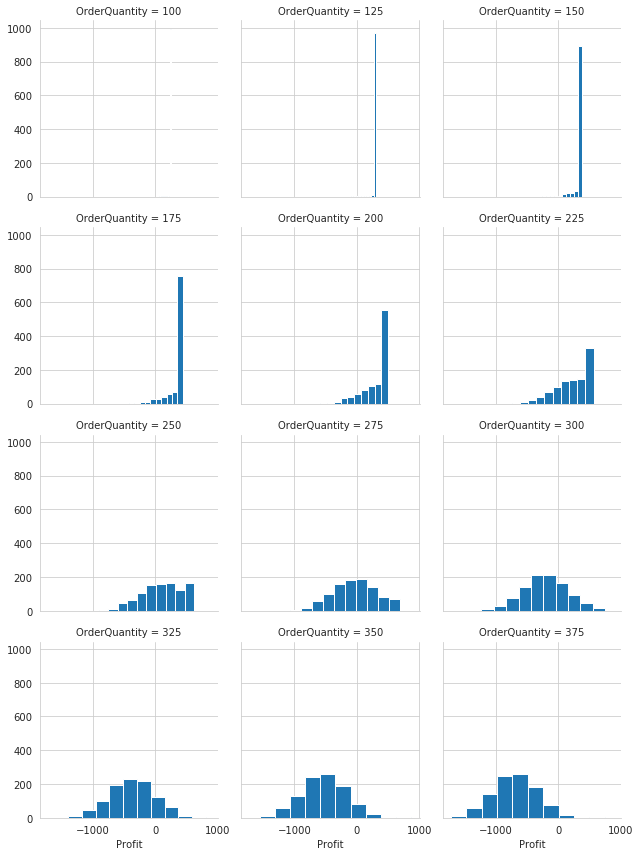

In [198]:
profit_histo_g = sns.FacetGrid(stbl_1_df, col="OrderQuantity", sharey=True, col_wrap=3)
profit_histo_g = profit_histo_g.map(plt.hist, "Profit")

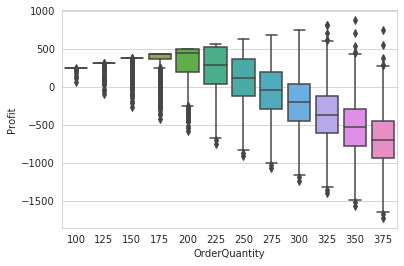

In [199]:
profit_box_g = sns.boxplot(x="OrderQuantity", y="Profit", data=stbl_1_df)